<br/>
$$ \huge{\underline{\textbf{ 1-Layer Neural Network }}} $$
<br/>

# Introduction

This notebook presents reference implementation of **1-layer neural network** trained with backpropagation.

Notebooks is split into parts:

* [Part 1](#Neural-Network): define neural network
* [Part 2a](#Solve-AND): solve AND mapping
* [Part 2b](#Solve-College-Admissions): solve college admissions problem

I say "neural network", but whole neural network is just single neuron with sigmoid activaiton function. We are going to use binary cross-entropy loss function because it has better convergence properties than mean squared error (as explained [here](http://neuralnetworksanddeeplearning.com/chap3.html#the_cross-entropy_cost_function). Fitting such single-layer single-neuron model is also called binary logistic regression.

**Model**

* one layer: **fully connected** with **sigmoid** activation
* loss: **binary cross-entropy**
* optimizer: **vanilla SGD**

**Recommended Reading**

* [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/) by Michael Nilsen - great introductory book on neural nets, free
* [Understanding Categorical Cross-Entropy Loss, Binary Cross-Entropy Loss, ...](https://gombru.github.io/2018/05/23/cross_entropy_loss/) - great post explaining various cross-entropy related loss functions
* [An Explanation of Xavier Initialization](http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization) - very good *why* we use Xavier initialization

# Neural Network

In [1]:
import numpy as np
import matplotlib.pyplot as plt

**Symbols**

All symbols are also defined in the text through the notebook.

| math | python | shape | comment |
|-|-|-|-|
| - | n_dataset | int | size of train dataset (\*) |
| n_batch | n_batch | int | size of mini-batch (\*) |
| n_in | n_in | int | number of input features |
| n_out | n_out | int | number of outputs (\*\*) |
| $x$ | x | (n_batch, n_in)  | inputs to model |
| $W$ | W | (n_in, n_out) | weights |
| $b$ | b | (1, n_out) | biases |
| $z$ | z | (n_batch, n_out) | preactivations |
| $y$ | y | (n_batch, n_out) | targets |
| $\hat{y}$ | y_hat | (n_batch, n_out) | model outputs [0..1] |
| $\sigma(z)$ | sigmoid() | - | sigmoid function |
| $J(y, \hat{y})$ | loss() | scalar | loss function |

* (\*) - for simplicity we feed in whole dataset all at once, so in this notebook n_batch and n_dataset are always equal
* (\*\*) - in this notebook *n_out* is always one, but depending on problem, model could have more than one output

**Overview**

Assuming *single training example* and two inputs, one output, our neural network will look as follows

<img src="assets/perceptron.png">

And input/output matrices would be single row

$$
x = 
\overset{\text{← n_in →}}{
  \begin{bmatrix}
  x_{11} & x_{12} \\
  \end{bmatrix}
}
\quad\quad\quad
\hat{y} =
\overset{\text{← n_out →}}{
  \begin{bmatrix}
  \ \ \hat{y}_{11} \ \ \\ 
  \end{bmatrix}
}
$$

**Sigmoid**

Sigmoid activation function - computed element wise

$$ \sigma(z) = \frac{1}{1+\epsilon^{-z}} \tag{eq. 1} $$

In [2]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

**Forward Pass**

All variables are 2d arrays. $x$, $W$ and $b$ denote input mini-batch, weights and biases respectively. *n_batch* is size of mini-batch, but in this notebook we always feed full dataset all at once. *n_in, n_out* are number of input features and number of outputs from the model (in this notebook nb_out is always one). $\hat{y}$ is output from the model.

Formulas

$$ z = xW + b \tag{eq 2}$$

$$ \hat{y} = \sigma(z) \tag{eq 3}$$

As computational graph

<img src="assets/0010_diag_fwd.png"/>

In [3]:
def forward(x, W, b):                #                                      x.shape (n_batch, n_in)
    z = x @ W + b                    # b is broadcasted by numpy            z.shape: (n_batch, n_out)
    return sigmoid( z )              #                                      shape: (n_batch, n_out)

**Loss**

$J(y,\hat{y})$ is a loss function. As mentioned before, we are using binary cross-entropy loss function. Binary CE is calculated element-wise for each $y$ and $\hat{y}$. Then if there is more than one output, sum over all outputs - note that some examples on the internet use average instead of summing, this doesn't really make much difference. At the end average over batch size. It's best to average here so when we change batch size we won't affect loss magnitude.

Loss

$$ J(y,\hat{y}) =  \frac{1}{\text{n_batch}} \sum_{t=1}^{\text{n_batch}}  \ \sum_{k=1}^{\text{n_out}} \  \big[ -y_{tk} \log(\hat{y_{tk}}) - (1-y_{tk})\log(1-\hat{y_{tk}}) \big] \tag{eq 4} $$

In [4]:
def loss(y, y_hat):                                   #                      y_hat, y.shape: (n_batch, n_out)
    result = -y*np.log(y_hat) -(1-y)*np.log(1-y_hat)  #                      result.shape: (n_batch, n_out)
    result = np.sum(result, axis=-1)                  # sum each example     result.shape: (n_batch, 1)
    return np.mean( result )                          # average over batch   shape: scalar

**Backpropagation**

Derivative of *both* sigmoid and binary cross-entropy. Proof is rather nice, see [here](https://www.ics.uci.edu/~pjsadows/notes.pdf)

$$ \frac{\partial J}{\partial z} = \frac{1}{\text{n_batch}} (\hat{y} - y) \tag{eq 5}$$

Derivatives wrt $W$ and $b$. This is basically backpropagation through matrix multiplication. Note that we are *not* calculating intermediate Jacobians (which would be sparse 4d-tensors). Instead at each backprop step we compute derivative wrt output $J$, which is $\frac{\partial J}{\partial \dots}$. $J$ is a scalar, and every other intermediate variable ($W$, $z$, $\hat{y}$) is at most 2d-matrix ($b$ is a vector), as such every intermediate partial derivative $\frac{\partial J}{\partial \dots}$ will be at most 2d-matrix as well. For more details how to derive these equations, see [here](http://cs231n.stanford.edu/handouts/linear-backprop.pdf) and [here](http://cs231n.stanford.edu/handouts/derivatives.pdf)

$$ \frac{\partial J}{\partial W} = \frac{1}{\text{n_batch}} x^T (\hat{y} - y) \tag{backprop through matmul; eq 6} $$

$$ \frac{\partial J}{\partial b} = \frac{1}{\text{n_batch}} \sum_{t=1}^{\text{n_batch}} (\hat{y_t} - y_t) \tag{eq 7} $$

As computational graph

<img src="assets/0010_diag_back.png"/>

Shapes of all derivatives of course match shapes of corresponding variables.

**Train Loop**

This function contains everything. Pass in full dataset (inputs x, targets y) and randomly initialized weights $W$ and biases $b$. Because example problems in this notebook are super small, this function trains on whole dataset all at once, i.e. it doesn't pick mini-batches. $W$ and $b$ are updated in-place.

In [5]:
def train_classifier(x, y, nb_epochs, learning_rate, W, b):
    """Params:
        x - inputs  - shape: (n_dataset, n_in)
        y - targets - shape: (n_dataset, n_out)
        nb_epochs - number of full passes over dataset
        W - weights, modified in place - shape: (nb_in, nb_out)
        b - biases, modified in place  - shape: (1, nb_out)
    Note: in this notebook nb_out is always equal to one
    """
    losses = []                                                 # keep track of losses for plotting

    for e in range(nb_epochs):
                
        # Forward Pass
        z = x @ W + b                                           # (eq 2)    z.shape: (batch_size, nb_neurons)
        y_hat = sigmoid(z)                                      # (eq 3)    y_hat.shape: (batch_size, nb_neurons)
        
        # Backward Pass
        rho = y_hat - y                                         #           combined sigmoid and binary CE derivative
        dW = (x.T @ rho) / len(x)                               # (eq 6)    backprop through matmul
        db = np.sum(rho, axis=0, keepdims=True) / len(x)        # (eq 7)
        
        # Gradient Check (defined at the end of the notebook)
        # ngW, ngb = numerical_gradient(x, y, W, b)
        # assert np.allclose(ngW, dW) and np.allclose(ngb, db)

        # Update weights
        W += -learning_rate * dW
        b += -learning_rate * db

        # Log and Print
        loss_train = loss(y, y_hat)                             # binary cross-entropy
        losses.append(loss_train)                               # save for plotting
        if e % (nb_epochs / 10) == 0:
            print('loss ', loss_train.round(4))
            
    return losses

This concludes neural netwrok definiton.

# Solve AND

Mapping we are trying to learn:

| $x_1$ | $x_2$ | → | $y$ |
|---|---|---|--|
| 0 | 0 | → | 0 |
| 0 | 1 | → | 0 |
| 1 | 0 | → | 0 |
| 1 | 1 | → | 1 |

Dataset

In [6]:
# training examples   x1   x2
x_train = np.array([[0.0, 0.0],
                    [0.0, 1.0],
                    [1.0, 0.0],
                    [1.0, 1.0]])

# training targets    y
y_train = np.array([[0.0],
                    [0.0],
                    [0.0],
                    [1.0]])

Create neural network (Xavier initialization explained quite well [here](http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization))

In [7]:
# Hyperparams
nb_epochs = 2000
learning_rate = 1

# Initialize
np.random.seed(0)                                                             # for reproducibility
nb_inputs, nb_outputs = 2, 1                                                  # 2 input columns, 1 output per example
W = np.random.normal(scale=1/nb_inputs**.5, size=[nb_inputs, nb_outputs])     # Xavier init
b = np.zeros(shape=[1, nb_outputs])                                           # ok to init biases to zeros

Before training, with randomly initialized $W$

In [8]:
y_hat = forward(x_train, W, b).round(2)
print('x1, x2      target     model ')
print('[0, 0]   →   [0]      ', y_hat[0])
print('[0, 1]   →   [0]      ', y_hat[1])
print('[1, 0]   →   [0]      ', y_hat[2])
print('[1, 1]   →   [1]      ', y_hat[3])

x1, x2      target     model 
[0, 0]   →   [0]       [0.5]
[0, 1]   →   [0]       [0.57]
[1, 0]   →   [0]       [0.78]
[1, 1]   →   [1]       [0.82]


Train neural network

In [9]:
losses = train_classifier(x_train, y_train, nb_epochs, learning_rate, W, b)

loss  0.8084
loss  0.0793
loss  0.0424
loss  0.0287
loss  0.0216
loss  0.0173
loss  0.0144
loss  0.0124
loss  0.0108
loss  0.0096


After training

In [10]:
y_hat = forward(x_train, W, b).round(2)
print('x1, x2      target     model ')
print('[0, 0]   →   [0]      ', y_hat[0])
print('[0, 1]   →   [0]      ', y_hat[1])
print('[1, 0]   →   [0]      ', y_hat[2])
print('[1, 1]   →   [1]      ', y_hat[3])

x1, x2      target     model 
[0, 0]   →   [0]       [0.]
[0, 1]   →   [0]       [0.01]
[1, 0]   →   [0]       [0.01]
[1, 1]   →   [1]       [0.99]


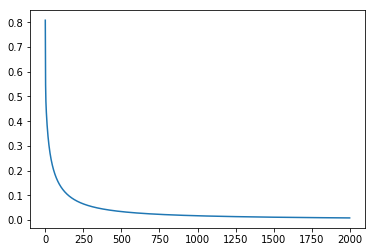

In [11]:
plt.plot(losses)

# Solve College Admissions

**Dataset**

We will use graduate school admissions data ([https://stats.idre.ucla.edu/stat/data/binary.csv]()). Each row is one student. Columns are as follows:
* admit - was student admitted or not? This is our target we will try to predict
* gre - student GRE score
* gpa - student GPA
* rank - prestige of undergrad school, 1 is highest, 4 is lowest

Extra Imports

In [12]:
import pandas as pd

Loda data with pandas

In [13]:
df = pd.read_csv('college_admissions.csv')

Show first couple rows. First column is index, added automatically by pandas.

In [14]:
df.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


Show some more information about dataset.

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
admit    400 non-null int64
gre      400 non-null int64
gpa      400 non-null float64
rank     400 non-null int64
dtypes: float64(1), int64(3)
memory usage: 12.6 KB


Plot data, each rank separately

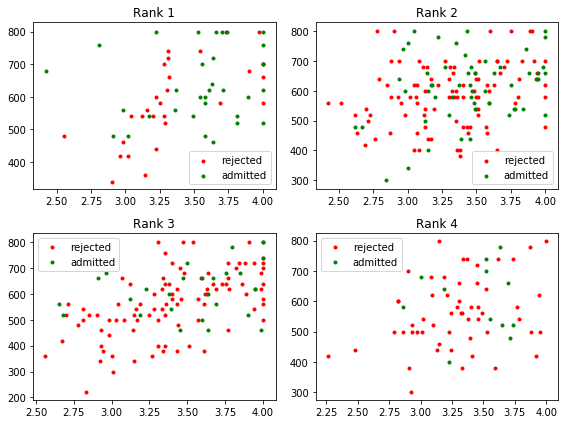

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[8,6])
axes = axes.flatten()
for i, rank in enumerate([1,2,3,4]):
    # pick not-admitted students with given rank
    tmp = df.loc[(df['rank']==rank) & (df['admit']==0)]
    axes[i].scatter(tmp['gpa'], tmp['gre'], color='red', marker='.', label='rejected')
    # pick admitted students with given rank
    tmp = df.loc[(df['rank']==rank) & (df['admit']==1)]
    axes[i].scatter(tmp['gpa'], tmp['gre'], color='green', marker='.', label='admitted')
    axes[i].set_title('Rank '+str(rank))
    axes[i].legend()
fig.tight_layout()

#### Preprocess

Code below does following things:
* convert _rank_ column into one-hot encoded features
* normalize _gre_ and _gpa_ columns to zero mean and unit standard deviation
* splits of 20% of data as test set
* splits into input features (gre, gpa, one-hot-rank) and targets (admit)
* convert into numpy
* assert shapes are ok

In [17]:
# Create dummies
temp = pd.get_dummies(df['rank'], prefix='rank')
data = pd.concat([df, temp], axis=1)
data.drop(columns='rank', inplace=True)

# Normalize
for col in ['gre', 'gpa']:
    mean, std = data[col].mean(), data[col].std()
    # data.loc[:, col] = (data[col]-mean) / std
    data[col] = (data[col]-mean) / std

# Split off random 20% of the data for testing
np.random.seed(0)
sample = np.random.choice(data.index, size=int(len(data)*0.9), replace=False)
data, test_data = data.iloc[sample], data.drop(sample)

# Split into features and targets
features_train = data.drop('admit', axis=1)
targets_train =  data['admit']
features_test = test_data.drop('admit', axis=1)
targets_test = test_data['admit']

# Convert to numpy
x_train = features_train.values            # features train set (numpy)
y_train = targets_train.values[:,None]     # targets train set (numpy)
x_test = features_test.values              # features validation set (numpy)
y_test = targets_test.values[:,None]       # targets valudation set (numpy)

# Assert shapes came right way around
assert x_train.shape == (360, 6)
assert y_train.shape == (360, 1)
assert x_test.shape == (40, 6)
assert y_test.shape == (40, 1)

#### Train Classifier

Create neural network

In [18]:
# Hyperparams
nb_epochs = 2000
learning_rate = 1

# Initialize
np.random.seed(0)                                                       # for reproducibility
n_inputs, n_outputs = x_train.shape[1], 1                               # get dataset shape
W = np.random.normal(scale=n_inputs**-.5, size=[n_inputs, n_outputs])   # Xavier init
b = np.zeros(shape=[1, n_outputs])

Train

In [19]:
losses = train_classifier(x_train, y_train, nb_epochs, learning_rate, W, b)

loss  0.8337
loss  0.5708
loss  0.5708
loss  0.5708
loss  0.5708
loss  0.5708
loss  0.5708
loss  0.5708
loss  0.5708
loss  0.5708


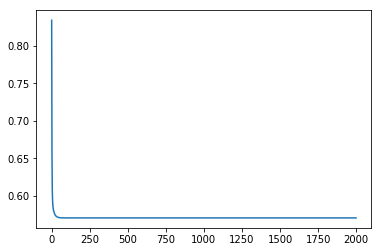

In [20]:
plt.plot(losses)

In [21]:
pred = forward(x_train, W, b)
pred = pred > 0.5
acc = np.mean(pred == y_train)
print('Accuracy on training set (expected ~0.7):', acc.round(2))

Accuracy on training set (expected ~0.7): 0.7


In [22]:
pred = forward(x_test, W, b)
pred = pred > 0.5
acc = np.mean(pred == y_test)
print('Accuracy on test set (expected ~0.75):', acc.round(2))

Accuracy on test set (expected ~0.75): 0.75


Note: accuracy on test set is usually worse than training set. College admissions dataset is very small and we just got lucky with easy test set when splitting into train/test sets.

# Numerical Gradient Check

Run this cell if you want to perform numerical gradient check in train_classifier()

In [23]:
def numerical_gradient(x, y, W, b):
    """Check gradient numerically"""
    assert W.ndim == 2
    assert b.ndim == 2
    assert b.shape[0] == 1
    
    eps = 1e-4
    
    # Weights
    del_W = np.zeros_like(W)    
    for r in range(W.shape[0]):
        for c in range(W.shape[1]):
            W_min = W.copy()
            W_pls = W.copy()
            
            W_min[r, c] -= eps
            W_pls[r, c] += eps
            
            y_hat_pls = forward(x, W_pls, b)
            y_hat_min = forward(x, W_min, b)
            
            l_pls = loss(y, y_hat_pls)
            l_min = loss(y, y_hat_min)

            del_W[r, c] = (l_pls - l_min) / (eps * 2)
            
    # Biases
    del_b = np.zeros_like(b)
    for c in range(b.shape[1]):
        b_min = b.copy()
        b_pls = b.copy()
            
        b_min[0, c] -= eps
        b_pls[0, c] += eps
            
        y_hat_pls = forward(x, W, b_pls)
        y_hat_min = forward(x, W, b_min)
            
        l_pls = loss(y, y_hat_pls)
        l_min = loss(y, y_hat_min)

        del_b[0, c] = (l_pls - l_min) / (eps * 2)
    
    return del_W, del_b

# Delete below

<font color="red">
REMOVE: Shapes are as follows

<font color="red">
$$
x = 
\scriptsize{
  \begin{matrix}
  ↑ \\ 
  \text{n_batch} \\ 
  ↓
  \end{matrix}
}\normalsize{}
\overset{\text{← n_in →}}{
  \begin{bmatrix}
  \cdot & \cdot  \\  
  \cdot & \cdot \\ 
  \cdot & \cdot 
  \end{bmatrix}
}
\quad\quad\quad
W =
\scriptsize{
  \begin{matrix}
  ↑ \\ 
  \text{n_in} \\ 
  ↓
  \end{matrix}
}\normalsize{}
\overset{\text{n_out}}{
  \begin{bmatrix}
  \cdot  \\ 
  \cdot  
  \end{bmatrix}
}
\quad\quad\quad
b =
\scriptsize{\text{1}}\normalsize{}
\overset{\text{n_out}}{
  \begin{bmatrix}
  \cdot \\ 
  \end{bmatrix}
}
$$

<font color="red">
REMOVE: Forward Pass

<font color="red">
$$ z = xW + b \tag{eq 2}$$

<font color="red">
$$ \hat{y} = \sigma(z) \tag{eq 3}$$

<font color="red">
Shapes are as follows

<font color="red">
$$
J(y,\hat{y}) = 
\begin{matrix}
\scriptsize{\text{(scalar)}} \\ 
\end{matrix}
\quad\quad\quad
y = 
\scriptsize{
  \begin{matrix}
  ↑ \\ 
  \text{n_batch} \\ 
  ↓
  \end{matrix}
}\normalsize{}
\overset{\text{n_out}}{
  \begin{bmatrix}
  \cdot  \\ 
  \cdot  \\ 
  \cdot 
  \end{bmatrix}
}
\quad\quad\quad
\hat{y} =
\scriptsize{
  \begin{matrix}
  ↑ \\ 
  \text{n_batch} \\ 
  ↓
  \end{matrix}
}\normalsize{}
\overset{\text{n_out}}{
  \begin{bmatrix}
  \cdot  \\ 
  \cdot  \\ 
  \cdot 
  \end{bmatrix}
}
$$